In [24]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import plotly.graph_objects as go
import scipy.io as scio
import random
from matplotlib import pyplot as plt
from scipy.integrate import odeint

In [25]:
def projectile_motion_with_resistance(state, t, g, k, m):
    x, y, v_x, v_y = state
    n = 3
    dx_dt = v_x
    dy_dt = v_y
    dv_x_dt = -(k/m) * v_x**n 
    dv_y_dt = -g - (k/m) * v_y**n
    
    return [dx_dt, dy_dt, dv_x_dt, dv_y_dt]

# 定义参数
g = 9.8  # 重力加速度
k = 0.1  # 空气阻力系数
m = 1.0  # 物体质量

# 定义初始条件
x0 = 0.0  # 初始水平位置
y0 = 10  # 初始垂直位置
v_x0 = 2.0  # 初始水平速度
v_y0 = 0  # 初始垂直速度

# 定义时间点
ts = np.linspace(0, 2, 1000)  # 从0到2秒，共取100个时间点

# 定义初始状态向量
initial_state = [x0, y0, v_x0, v_y0]

# 求解ODE方程组
solution_with_resistance = odeint(projectile_motion_with_resistance, initial_state, ts, args=(g, k, m))

# 提取位置和速度信息
x_with_resistance = solution_with_resistance[:, 0]
y_with_resistance = solution_with_resistance[:, 1]
v_x_with_resistance = solution_with_resistance[:, 2]
v_y_with_resistance = solution_with_resistance[:, 3]

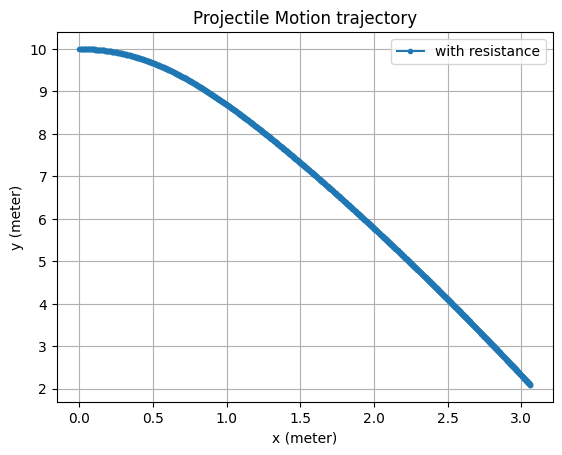

In [26]:
# 绘制轨迹
plt.plot(x_with_resistance, y_with_resistance, label = 'with resistance', marker='o', markersize = 3)
#plt.plot(state_list[:, 0], state_list[:, 1], label = 'Kalman Filter tracking', marker='o', markersize = 3)
plt.xlabel('x (meter)')
plt.ylabel('y (meter)')
plt.title('Projectile Motion trajectory')
plt.grid(True)
plt.legend()
plt.show()

In [27]:
n_train = 800
t_train = ts[:n_train]
x_train = x_with_resistance[:n_train]
y_train = y_with_resistance[:n_train]

In [28]:
# data preparation
n_f = 10000
f_batch_size = 32

reg_in = torch.from_numpy(t_train).type(torch.float32)
reg_in = reg_in[:,None]

label = np.vstack([x_train,y_train])
reg_label = torch.from_numpy(label.T).type(torch.float32)

print(reg_label.shape)

f_x = np.random.uniform(0, 5, n_f)
f_y = np.random.uniform(2, 10, n_f)
f_t = np.random.uniform(0, 2, n_f)

f_data = np.vstack([f_x, f_y, f_t]).T
f_input = Variable(torch.from_numpy(f_data[:, 0:2]).type(torch.FloatTensor), requires_grad=True)
f_t = Variable(torch.from_numpy(f_data[:, 2:3]).type(torch.FloatTensor), requires_grad=True)

f_dataset = torch.utils.data.TensorDataset(f_input, f_t)

f_data_loader_x = torch.utils.data.DataLoader(f_dataset, batch_size = f_batch_size, shuffle=True)


torch.Size([800, 2])


In [29]:
# Define a MLP and function f
class MLP(nn.Module):
    def __init__(self, in_dim = 1,  hidden_dim = 128, out_dim = 2):

        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
                                nn.Linear(in_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, out_dim),
                                        )

    def forward(self, data_in):
        return self.mlp(data_in)

model = MLP()

class f_t(nn.Module):

    def __init__(self):

        super(f_t, self).__init__()
        self.k = nn.Parameter(1*torch.ones(1, ), requires_grad=True)
        #self.m = nn.Parameter(1*torch.ones(1, ), requires_grad=True)
        #self.n = nn.Parameter(1*torch.ones(1, ), requires_grad=True)

    def forward(self, t):
        u = model(t)
        u_t_x = torch.autograd.grad(u[:,0:1], t, grad_outputs=torch.ones_like(u[:,0:1]),
                                  create_graph=True, retain_graph=True)[0]
        u_tt_x = torch.autograd.grad(u_t_x, t, grad_outputs=torch.ones_like(u[:,0:1]),
                                  create_graph=True, retain_graph=True)[0]

        u_t_y = torch.autograd.grad(u[:,1:2], t, grad_outputs=torch.ones_like(u[:,1:2]),
                                  create_graph=True, retain_graph=True)[0]
        u_tt_y = torch.autograd.grad(u_t_y, t, grad_outputs=torch.ones_like(u[:,1:2]),
                                  create_graph=True, retain_graph=True)[0]
        return u_tt_x + (self.k)*u_t_x**3 + u_tt_y + (self.k)*u_t_y**3 + 9.8


In [30]:
# Training the PINN
n_epoch = 100
f_model = f_t()
paras = list(model.parameters()) + list(f_model.parameters())
optimizer_x = optim.Adam(paras, lr=1e-3)
Alpha_k = np.zeros(n_epoch,)
Alpha_m = np.zeros(n_epoch,)
Alpha_n = np.zeros(n_epoch,)

for epoch in range(n_epoch):
    for x, t in tqdm(f_data_loader_x):

        optimizer_x.zero_grad()
        pred = model(reg_in)
        reg_loss = torch.mean((reg_label - pred) ** 2)
        
        f_loss = torch.mean(f_model(t) ** 2)

        loss =  reg_loss +f_loss   # adjust the coefficients between two losses
        loss.backward(retain_graph=True)
        optimizer_x.step()

    print("epoch = {}, loss = {}".format(epoch, loss))
    print("epoch = {}, f_loss = {}".format(epoch, f_loss))
    print("epoch = {}, reg_loss = {}".format(epoch, reg_loss))

    Alpha_k[epoch] = f_model.k.detach().numpy().item()
    #Alpha_m[epoch] = f_model.m.detach().numpy().item()
    #Alpha_n[epoch] = f_model.n.detach().numpy().item()


100%|██████████| 313/313 [00:02<00:00, 155.96it/s]


epoch = 0, loss = 0.4644447863101959
epoch = 0, f_loss = 0.003147974843159318
epoch = 0, reg_loss = 0.46129679679870605


100%|██████████| 313/313 [00:02<00:00, 156.43it/s]


epoch = 1, loss = 0.29817137122154236
epoch = 1, f_loss = 0.0028309104964137077
epoch = 1, reg_loss = 0.2953404486179352


100%|██████████| 313/313 [00:02<00:00, 155.75it/s]


epoch = 2, loss = 0.30172815918922424
epoch = 2, f_loss = 0.02120799757540226
epoch = 2, reg_loss = 0.28052017092704773


100%|██████████| 313/313 [00:02<00:00, 155.94it/s]


epoch = 3, loss = 0.24721698462963104
epoch = 3, f_loss = 0.004056885838508606
epoch = 3, reg_loss = 0.24316009879112244


100%|██████████| 313/313 [00:02<00:00, 155.32it/s]


epoch = 4, loss = 0.2681513726711273
epoch = 4, f_loss = 0.029591506347060204
epoch = 4, reg_loss = 0.23855985701084137


100%|██████████| 313/313 [00:02<00:00, 155.42it/s]


epoch = 5, loss = 0.2959621846675873
epoch = 5, f_loss = 0.05651005357503891
epoch = 5, reg_loss = 0.23945213854312897


100%|██████████| 313/313 [00:01<00:00, 156.92it/s]


epoch = 6, loss = 0.24079568684101105
epoch = 6, f_loss = 0.009348560124635696
epoch = 6, reg_loss = 0.23144713044166565


100%|██████████| 313/313 [00:01<00:00, 157.92it/s]


epoch = 7, loss = 0.2628289461135864
epoch = 7, f_loss = 0.015859102830290794
epoch = 7, reg_loss = 0.24696983397006989


100%|██████████| 313/313 [00:01<00:00, 158.12it/s]


epoch = 8, loss = 0.4614366888999939
epoch = 8, f_loss = 0.17875270545482635
epoch = 8, reg_loss = 0.28268396854400635


100%|██████████| 313/313 [00:01<00:00, 157.42it/s]


epoch = 9, loss = 0.23056145012378693
epoch = 9, f_loss = 0.0032899724319577217
epoch = 9, reg_loss = 0.22727148234844208


100%|██████████| 313/313 [00:01<00:00, 156.83it/s]


epoch = 10, loss = 0.22643998265266418
epoch = 10, f_loss = 0.0011143260635435581
epoch = 10, reg_loss = 0.22532565891742706


100%|██████████| 313/313 [00:01<00:00, 157.34it/s]


epoch = 11, loss = 0.2734936773777008
epoch = 11, f_loss = 0.04514370113611221
epoch = 11, reg_loss = 0.2283499836921692


100%|██████████| 313/313 [00:02<00:00, 156.03it/s]


epoch = 12, loss = 0.2990020513534546
epoch = 12, f_loss = 0.08239203691482544
epoch = 12, reg_loss = 0.21661002933979034


100%|██████████| 313/313 [00:01<00:00, 156.88it/s]


epoch = 13, loss = 0.7370036840438843
epoch = 13, f_loss = 0.5262367129325867
epoch = 13, reg_loss = 0.2107669711112976


100%|██████████| 313/313 [00:01<00:00, 157.23it/s]


epoch = 14, loss = 0.21382252871990204
epoch = 14, f_loss = 0.001556152943521738
epoch = 14, reg_loss = 0.21226637065410614


100%|██████████| 313/313 [00:02<00:00, 155.60it/s]


epoch = 15, loss = 0.22330345213413239
epoch = 15, f_loss = 0.002299020765349269
epoch = 15, reg_loss = 0.2210044264793396


100%|██████████| 313/313 [00:01<00:00, 157.01it/s]


epoch = 16, loss = 0.211394801735878
epoch = 16, f_loss = 0.002064764266833663
epoch = 16, reg_loss = 0.20933003723621368


100%|██████████| 313/313 [00:01<00:00, 157.21it/s]


epoch = 17, loss = 0.2668081223964691
epoch = 17, f_loss = 0.04691645875573158
epoch = 17, reg_loss = 0.21989166736602783


100%|██████████| 313/313 [00:01<00:00, 156.53it/s]


epoch = 18, loss = 0.21530458331108093
epoch = 18, f_loss = 0.012925426475703716
epoch = 18, reg_loss = 0.20237915217876434


100%|██████████| 313/313 [00:01<00:00, 157.03it/s]


epoch = 19, loss = 0.4884222745895386
epoch = 19, f_loss = 0.2939724326133728
epoch = 19, reg_loss = 0.19444982707500458


100%|██████████| 313/313 [00:02<00:00, 155.72it/s]


epoch = 20, loss = 0.21209457516670227
epoch = 20, f_loss = 0.008657419122755527
epoch = 20, reg_loss = 0.20343714952468872


100%|██████████| 313/313 [00:02<00:00, 156.23it/s]


epoch = 21, loss = 0.20720724761486053
epoch = 21, f_loss = 0.01166442409157753
epoch = 21, reg_loss = 0.1955428272485733


100%|██████████| 313/313 [00:01<00:00, 156.89it/s]


epoch = 22, loss = 0.19930493831634521
epoch = 22, f_loss = 0.005136988591402769
epoch = 22, reg_loss = 0.19416795670986176


100%|██████████| 313/313 [00:01<00:00, 156.81it/s]


epoch = 23, loss = 0.19068290293216705
epoch = 23, f_loss = 0.0015052417293190956
epoch = 23, reg_loss = 0.18917766213417053


100%|██████████| 313/313 [00:01<00:00, 157.21it/s]


epoch = 24, loss = 0.20488879084587097
epoch = 24, f_loss = 0.002174540888518095
epoch = 24, reg_loss = 0.2027142494916916


100%|██████████| 313/313 [00:01<00:00, 157.42it/s]


epoch = 25, loss = 0.19579556584358215
epoch = 25, f_loss = 0.009014906361699104
epoch = 25, reg_loss = 0.1867806613445282


100%|██████████| 313/313 [00:02<00:00, 156.24it/s]


epoch = 26, loss = 0.18568605184555054
epoch = 26, f_loss = 0.003410014556720853
epoch = 26, reg_loss = 0.18227604031562805


100%|██████████| 313/313 [00:02<00:00, 154.99it/s]


epoch = 27, loss = 0.18712638318538666
epoch = 27, f_loss = 0.010954122059047222
epoch = 27, reg_loss = 0.17617225646972656


100%|██████████| 313/313 [00:02<00:00, 155.16it/s]


epoch = 28, loss = 0.1755020022392273
epoch = 28, f_loss = 0.00039091543294489384
epoch = 28, reg_loss = 0.1751110851764679


100%|██████████| 313/313 [00:01<00:00, 157.22it/s]


epoch = 29, loss = 0.5491319894790649
epoch = 29, f_loss = 0.33636927604675293
epoch = 29, reg_loss = 0.212762713432312


100%|██████████| 313/313 [00:01<00:00, 156.79it/s]


epoch = 30, loss = 0.17517349123954773
epoch = 30, f_loss = 0.004838254768401384
epoch = 30, reg_loss = 0.17033523321151733


100%|██████████| 313/313 [00:02<00:00, 156.41it/s]


epoch = 31, loss = 0.1788756549358368
epoch = 31, f_loss = 0.013764805160462856
epoch = 31, reg_loss = 0.16511085629463196


100%|██████████| 313/313 [00:02<00:00, 156.31it/s]


epoch = 32, loss = 0.1634555459022522
epoch = 32, f_loss = 0.0015013243537396193
epoch = 32, reg_loss = 0.16195422410964966


100%|██████████| 313/313 [00:01<00:00, 156.91it/s]


epoch = 33, loss = 0.16435354948043823
epoch = 33, f_loss = 0.005773996002972126
epoch = 33, reg_loss = 0.15857955813407898


100%|██████████| 313/313 [00:01<00:00, 156.66it/s]


epoch = 34, loss = 0.21791453659534454
epoch = 34, f_loss = 0.05596209689974785
epoch = 34, reg_loss = 0.1619524359703064


100%|██████████| 313/313 [00:02<00:00, 156.26it/s]


epoch = 35, loss = 0.1523537039756775
epoch = 35, f_loss = 0.00024314536130987108
epoch = 35, reg_loss = 0.15211056172847748


100%|██████████| 313/313 [00:02<00:00, 155.99it/s]


epoch = 36, loss = 0.1656705141067505
epoch = 36, f_loss = 0.01710483245551586
epoch = 36, reg_loss = 0.14856567978858948


100%|██████████| 313/313 [00:01<00:00, 157.67it/s]


epoch = 37, loss = 0.1446373015642166
epoch = 37, f_loss = 0.000337941397447139
epoch = 37, reg_loss = 0.14429935812950134


100%|██████████| 313/313 [00:01<00:00, 158.11it/s]


epoch = 38, loss = 0.22772538661956787
epoch = 38, f_loss = 0.08474815636873245
epoch = 38, reg_loss = 0.14297722280025482


100%|██████████| 313/313 [00:01<00:00, 158.36it/s]


epoch = 39, loss = 0.2216617465019226
epoch = 39, f_loss = 0.08389375358819962
epoch = 39, reg_loss = 0.1377680003643036


100%|██████████| 313/313 [00:01<00:00, 157.85it/s]


epoch = 40, loss = 0.1350659877061844
epoch = 40, f_loss = 0.001233621733263135
epoch = 40, reg_loss = 0.13383236527442932


100%|██████████| 313/313 [00:01<00:00, 157.82it/s]


epoch = 41, loss = 0.12817072868347168
epoch = 41, f_loss = 0.000498597277328372
epoch = 41, reg_loss = 0.12767213582992554


100%|██████████| 313/313 [00:01<00:00, 158.12it/s]


epoch = 42, loss = 0.18703153729438782
epoch = 42, f_loss = 0.06160349026322365
epoch = 42, reg_loss = 0.12542805075645447


100%|██████████| 313/313 [00:01<00:00, 158.08it/s]


epoch = 43, loss = 0.13106444478034973
epoch = 43, f_loss = 0.009892355650663376
epoch = 43, reg_loss = 0.12117209285497665


100%|██████████| 313/313 [00:02<00:00, 155.58it/s]


epoch = 44, loss = 0.11894126236438751
epoch = 44, f_loss = 0.006523953750729561
epoch = 44, reg_loss = 0.1124173104763031


100%|██████████| 313/313 [00:02<00:00, 154.98it/s]


epoch = 45, loss = 0.10951339453458786
epoch = 45, f_loss = 0.0025518303737044334
epoch = 45, reg_loss = 0.10696156322956085


100%|██████████| 313/313 [00:01<00:00, 157.20it/s]


epoch = 46, loss = 0.14222434163093567
epoch = 46, f_loss = 0.04214361310005188
epoch = 46, reg_loss = 0.10008072108030319


100%|██████████| 313/313 [00:01<00:00, 157.66it/s]


epoch = 47, loss = 0.09839718788862228
epoch = 47, f_loss = 0.004248493351042271
epoch = 47, reg_loss = 0.09414869546890259


100%|██████████| 313/313 [00:01<00:00, 156.99it/s]


epoch = 48, loss = 0.09133515506982803
epoch = 48, f_loss = 0.003956052474677563
epoch = 48, reg_loss = 0.0873791053891182


100%|██████████| 313/313 [00:01<00:00, 157.64it/s]


epoch = 49, loss = 0.15988010168075562
epoch = 49, f_loss = 0.08056966960430145
epoch = 49, reg_loss = 0.07931043207645416


100%|██████████| 313/313 [00:01<00:00, 157.90it/s]


epoch = 50, loss = 0.0734875500202179
epoch = 50, f_loss = 0.0010719354031607509
epoch = 50, reg_loss = 0.07241561263799667


100%|██████████| 313/313 [00:01<00:00, 156.63it/s]


epoch = 51, loss = 0.07375584542751312
epoch = 51, f_loss = 0.008356846868991852
epoch = 51, reg_loss = 0.06539899855852127


100%|██████████| 313/313 [00:02<00:00, 155.41it/s]


epoch = 52, loss = 0.06660809367895126
epoch = 52, f_loss = 0.00847072247415781
epoch = 52, reg_loss = 0.05813736841082573


100%|██████████| 313/313 [00:01<00:00, 156.92it/s]


epoch = 53, loss = 0.05298316106200218
epoch = 53, f_loss = 0.0014820030191913247
epoch = 53, reg_loss = 0.051501158624887466


100%|██████████| 313/313 [00:01<00:00, 157.05it/s]


epoch = 54, loss = 0.043176475912332535
epoch = 54, f_loss = 0.00020587362814694643
epoch = 54, reg_loss = 0.042970601469278336


100%|██████████| 313/313 [00:01<00:00, 157.24it/s]


epoch = 55, loss = 0.038168661296367645
epoch = 55, f_loss = 0.002488379366695881
epoch = 55, reg_loss = 0.03568028286099434


100%|██████████| 313/313 [00:02<00:00, 156.20it/s]


epoch = 56, loss = 0.05717821419239044
epoch = 56, f_loss = 0.029233330860733986
epoch = 56, reg_loss = 0.027944881469011307


100%|██████████| 313/313 [00:02<00:00, 155.47it/s]


epoch = 57, loss = 0.06067952513694763
epoch = 57, f_loss = 0.03831707313656807
epoch = 57, reg_loss = 0.02236245386302471


100%|██████████| 313/313 [00:02<00:00, 155.75it/s]


epoch = 58, loss = 0.019517812877893448
epoch = 58, f_loss = 0.0009667181293480098
epoch = 58, reg_loss = 0.018551094457507133


100%|██████████| 313/313 [00:02<00:00, 156.03it/s]


epoch = 59, loss = 0.21824467182159424
epoch = 59, f_loss = 0.20376107096672058
epoch = 59, reg_loss = 0.014483606442809105


100%|██████████| 313/313 [00:02<00:00, 154.65it/s]


epoch = 60, loss = 0.0139386635273695
epoch = 60, f_loss = 0.0027271010912954807
epoch = 60, reg_loss = 0.011211562901735306


100%|██████████| 313/313 [00:02<00:00, 155.57it/s]


epoch = 61, loss = 0.008884552866220474
epoch = 61, f_loss = 0.0005292647401802242
epoch = 61, reg_loss = 0.008355287835001945


100%|██████████| 313/313 [00:02<00:00, 155.91it/s]


epoch = 62, loss = 0.07066679000854492
epoch = 62, f_loss = 0.06273234635591507
epoch = 62, reg_loss = 0.00793444737792015


100%|██████████| 313/313 [00:02<00:00, 155.83it/s]


epoch = 63, loss = 0.005394676700234413
epoch = 63, f_loss = 0.000444275327026844
epoch = 63, reg_loss = 0.004950401373207569


100%|██████████| 313/313 [00:02<00:00, 155.81it/s]


epoch = 64, loss = 0.00509214773774147
epoch = 64, f_loss = 0.0013400849420577288
epoch = 64, reg_loss = 0.0037520630285143852


100%|██████████| 313/313 [00:01<00:00, 157.36it/s]


epoch = 65, loss = 0.03744436427950859
epoch = 65, f_loss = 0.03442680463194847
epoch = 65, reg_loss = 0.003017559414729476


100%|██████████| 313/313 [00:01<00:00, 157.26it/s]


epoch = 66, loss = 0.001779962913133204
epoch = 66, f_loss = 7.869934051996097e-05
epoch = 66, reg_loss = 0.0017012635944411159


100%|██████████| 313/313 [00:01<00:00, 157.06it/s]


epoch = 67, loss = 0.0036200368776917458
epoch = 67, f_loss = 0.002540700137615204
epoch = 67, reg_loss = 0.00107933662366122


100%|██████████| 313/313 [00:02<00:00, 151.93it/s]


epoch = 68, loss = 0.0013603443512693048
epoch = 68, f_loss = 0.0001696400431683287
epoch = 68, reg_loss = 0.0011907042935490608


100%|██████████| 313/313 [00:02<00:00, 154.69it/s]


epoch = 69, loss = 0.0006027452182024717
epoch = 69, f_loss = 7.386875950032845e-05
epoch = 69, reg_loss = 0.0005288764368742704


100%|██████████| 313/313 [00:02<00:00, 156.01it/s]


epoch = 70, loss = 0.0004227996396366507
epoch = 70, f_loss = 2.821153793775011e-05
epoch = 70, reg_loss = 0.00039458810351789


100%|██████████| 313/313 [00:02<00:00, 155.82it/s]


epoch = 71, loss = 0.0008850534213706851
epoch = 71, f_loss = 0.0005568991182371974
epoch = 71, reg_loss = 0.00032815427402965724


100%|██████████| 313/313 [00:02<00:00, 156.33it/s]


epoch = 72, loss = 0.005516217090189457
epoch = 72, f_loss = 0.005263376049697399
epoch = 72, reg_loss = 0.00025284115690737963


100%|██████████| 313/313 [00:02<00:00, 155.93it/s]


epoch = 73, loss = 0.0015954590635374188
epoch = 73, f_loss = 0.0011721777264028788
epoch = 73, reg_loss = 0.00042328136623837054


100%|██████████| 313/313 [00:02<00:00, 153.61it/s]


epoch = 74, loss = 0.004549804143607616
epoch = 74, f_loss = 0.0042298901826143265
epoch = 74, reg_loss = 0.0003199138445779681


100%|██████████| 313/313 [00:02<00:00, 152.96it/s]


epoch = 75, loss = 0.0456838421523571
epoch = 75, f_loss = 0.04358494654297829
epoch = 75, reg_loss = 0.0020988963078707457


100%|██████████| 313/313 [00:02<00:00, 155.66it/s]


epoch = 76, loss = 0.0005867975996807218
epoch = 76, f_loss = 0.00036953779635950923
epoch = 76, reg_loss = 0.00021725977421738207


100%|██████████| 313/313 [00:02<00:00, 154.55it/s]


epoch = 77, loss = 0.000747878453694284
epoch = 77, f_loss = 0.0005812807939946651
epoch = 77, reg_loss = 0.00016659763059578836


100%|██████████| 313/313 [00:01<00:00, 156.79it/s]


epoch = 78, loss = 0.0009778530802577734
epoch = 78, f_loss = 0.0008135400130413473
epoch = 78, reg_loss = 0.0001643130963202566


100%|██████████| 313/313 [00:01<00:00, 156.70it/s]


epoch = 79, loss = 0.0007962012896314263
epoch = 79, f_loss = 0.00046558998292312026
epoch = 79, reg_loss = 0.0003306113067083061


100%|██████████| 313/313 [00:01<00:00, 156.81it/s]


epoch = 80, loss = 0.0004236398381181061
epoch = 80, f_loss = 0.00023840743233449757
epoch = 80, reg_loss = 0.00018523239123169333


100%|██████████| 313/313 [00:02<00:00, 155.12it/s]


epoch = 81, loss = 0.00030387809965759516
epoch = 81, f_loss = 0.00014954188372939825
epoch = 81, reg_loss = 0.00015433623048011214


100%|██████████| 313/313 [00:01<00:00, 156.59it/s]


epoch = 82, loss = 0.04369845241308212
epoch = 82, f_loss = 0.04015979915857315
epoch = 82, reg_loss = 0.003538653254508972


100%|██████████| 313/313 [00:01<00:00, 156.52it/s]


epoch = 83, loss = 0.0004409939865581691
epoch = 83, f_loss = 0.00014918854867573828
epoch = 83, reg_loss = 0.0002918054233305156


100%|██████████| 313/313 [00:02<00:00, 156.24it/s]


epoch = 84, loss = 0.0003348980098962784
epoch = 84, f_loss = 9.912725363392383e-05
epoch = 84, reg_loss = 0.00023577075626235455


100%|██████████| 313/313 [00:02<00:00, 156.21it/s]


epoch = 85, loss = 0.002452548360452056
epoch = 85, f_loss = 0.002150268293917179
epoch = 85, reg_loss = 0.0003022800665348768


100%|██████████| 313/313 [00:02<00:00, 156.17it/s]


epoch = 86, loss = 0.024262597784399986
epoch = 86, f_loss = 0.021425791084766388
epoch = 86, reg_loss = 0.0028368064668029547


100%|██████████| 313/313 [00:02<00:00, 155.55it/s]


epoch = 87, loss = 0.00035341104376129806
epoch = 87, f_loss = 1.2769290151481982e-05
epoch = 87, reg_loss = 0.0003406417672522366


100%|██████████| 313/313 [00:02<00:00, 156.10it/s]


epoch = 88, loss = 0.0002929764741566032
epoch = 88, f_loss = 2.3142612917581573e-05
epoch = 88, reg_loss = 0.00026983386487700045


100%|██████████| 313/313 [00:02<00:00, 154.83it/s]


epoch = 89, loss = 0.011568040587008
epoch = 89, f_loss = 0.010453402996063232
epoch = 89, reg_loss = 0.0011146377073600888


100%|██████████| 313/313 [00:02<00:00, 155.09it/s]


epoch = 90, loss = 0.0009052632958628237
epoch = 90, f_loss = 0.0006251073209568858
epoch = 90, reg_loss = 0.0002801559749059379


100%|██████████| 313/313 [00:01<00:00, 157.05it/s]


epoch = 91, loss = 0.0015864805318415165
epoch = 91, f_loss = 0.0013437599409371614
epoch = 91, reg_loss = 0.00024272054724860936


100%|██████████| 313/313 [00:01<00:00, 156.52it/s]


epoch = 92, loss = 0.0012324193958193064
epoch = 92, f_loss = 0.0005596769042313099
epoch = 92, reg_loss = 0.0006727425497956574


100%|██████████| 313/313 [00:02<00:00, 155.45it/s]


epoch = 93, loss = 0.0004900750354863703
epoch = 93, f_loss = 0.00017214090621564537
epoch = 93, reg_loss = 0.0003179341438226402


100%|██████████| 313/313 [00:02<00:00, 155.38it/s]


epoch = 94, loss = 0.0009012977825477719
epoch = 94, f_loss = 0.0006301191169768572
epoch = 94, reg_loss = 0.0002711786946747452


100%|██████████| 313/313 [00:02<00:00, 156.06it/s]


epoch = 95, loss = 0.0010207562008872628
epoch = 95, f_loss = 0.0007336864364333451
epoch = 95, reg_loss = 0.00028706976445391774


100%|██████████| 313/313 [00:02<00:00, 155.77it/s]


epoch = 96, loss = 0.008546032011508942
epoch = 96, f_loss = 0.007919500581920147
epoch = 96, reg_loss = 0.000626531895250082


100%|██████████| 313/313 [00:02<00:00, 153.75it/s]


epoch = 97, loss = 0.0015833277720957994
epoch = 97, f_loss = 0.001259121811017394
epoch = 97, reg_loss = 0.00032420590287074447


100%|██████████| 313/313 [00:02<00:00, 155.00it/s]


epoch = 98, loss = 0.0004458143375813961
epoch = 98, f_loss = 0.00016208940360229462
epoch = 98, reg_loss = 0.00028372491942718625


100%|██████████| 313/313 [00:02<00:00, 156.36it/s]

epoch = 99, loss = 0.0006153727881610394
epoch = 99, f_loss = 0.0002828901633620262
epoch = 99, reg_loss = 0.0003324825956951827


In [31]:
# Train a pure MLP in x direction
model_mlp = MLP()
optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=1e-3)
for epoch in range(1000):

        optimizer_mlp.zero_grad()
        pred = model_mlp(reg_in)
        mlp_loss = torch.mean((reg_label - pred) ** 2)
        mlp_loss.backward()
        optimizer_mlp.step()
        print("epoch = {}, loss = {}".format(epoch, mlp_loss))

epoch = 0, loss = 29.83407211303711
epoch = 1, loss = 26.900829315185547
epoch = 2, loss = 24.080917358398438
epoch = 3, loss = 21.334796905517578
epoch = 4, loss = 18.659440994262695
epoch = 5, loss = 16.083890914916992
epoch = 6, loss = 13.656022071838379
epoch = 7, loss = 11.428461074829102
epoch = 8, loss = 9.446744918823242
epoch = 9, loss = 7.740114688873291
epoch = 10, loss = 6.317044258117676
epoch = 11, loss = 5.166329860687256
epoch = 12, loss = 4.26223611831665
epoch = 13, loss = 3.5710668563842773
epoch = 14, loss = 3.0569827556610107
epoch = 15, loss = 2.685887098312378
epoch = 16, loss = 2.427388906478882
epoch = 17, loss = 2.255403995513916
epoch = 18, loss = 2.148098945617676
epoch = 19, loss = 2.087658643722534
epoch = 20, loss = 2.059999942779541
epoch = 21, loss = 2.054354190826416
epoch = 22, loss = 2.0627124309539795
epoch = 23, loss = 2.079238176345825
epoch = 24, loss = 2.099741220474243
epoch = 25, loss = 2.1212570667266846
epoch = 26, loss = 2.141714096069336
e

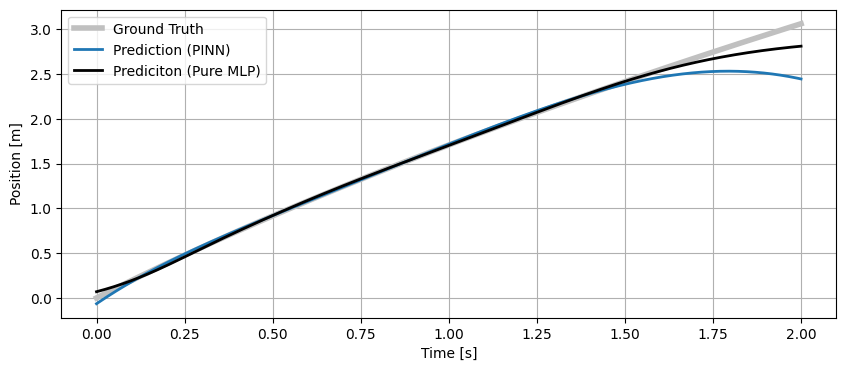

In [32]:
# Time series

ts_torch = torch.from_numpy(ts).type(torch.float32)
ts_torch = ts_torch[:,None]

plt.figure(figsize=(10, 4))
plt.plot(ts, x_with_resistance,color = "silver", lw = 4)
plt.plot(ts, model( ts_torch )[:,0:1].detach().numpy(),lw = 2)
plt.plot(ts, model_mlp( ts_torch )[:,0:1].detach().numpy(), color = "black", lw = 2)
#plt.scatter(t_train, x_train,alpha=0.5, c = "red")
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['Ground Truth', 'Prediction (PINN)', "Prediciton (Pure MLP)","measured data"])
plt.grid(True)

Parameter containing:
tensor([0.0954], requires_grad=True)


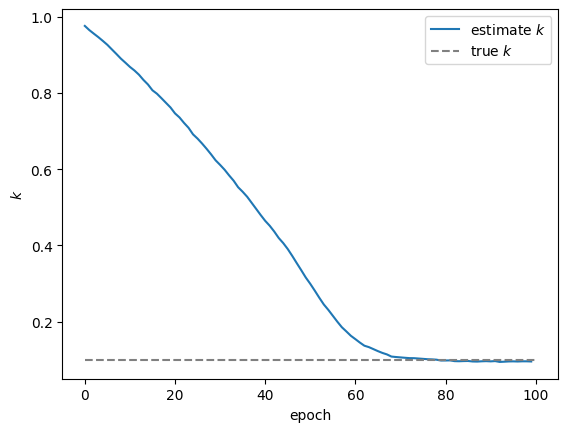

In [33]:
print(f_model.k)

plt.plot(np.asarray(Alpha_k), label = r"estimate $k$")
plt.plot(np.linspace(0,n_epoch, n_epoch), k*np.ones(n_epoch),"--", color = "gray", label = r"true $k$")
plt.ylabel(r"$k$")
plt.xlabel("epoch")
plt.legend()

In [34]:
print(f_model.m)

plt.plot(np.asarray(Alpha_m), label = r"estimate $m$")
plt.plot(np.linspace(0,n_epoch, n_epoch), m*np.ones(n_epoch),"--", color = "gray", label = r"true $m$")
plt.ylabel(r"$c$")
plt.xlabel("epoch")
plt.legend()

AttributeError: 'f_t' object has no attribute 'm'

In [ ]:
print(f_model.n)

plt.plot(np.asarray(Alpha_m), label = r"estimate $n$")
plt.plot(np.linspace(0,n_epoch, n_epoch), 3*np.ones(n_epoch),"--", color = "gray", label = r"true $n$")
plt.ylabel(r"$c$")
plt.xlabel("epoch")
plt.legend()

AttributeError: 'f_t' object has no attribute 'n'

In [ ]:
print(f_model.g)

plt.plot(np.asarray(Alpha_m), label = r"estimate $g$")
plt.plot(np.linspace(0,n_epoch, n_epoch), 3*np.ones(n_epoch),"--", color = "gray", label = r"true $g$")
plt.ylabel(r"$c$")
plt.xlabel("epoch")
plt.legend()